In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp '/content/drive/MyDrive/Copy of HV-AI-2024.zip' /content/HV-AI-2024.zip
!unzip HV-AI-2024.zip
!rm -rf /content/__MACOSX
!mv /content/HV-AI-2024/* /content/
!rm -rf /content/HV-AI-2024
!rm /content/HV-AI-2024.zip
!rm -rf /content/sample_data


Streaming output truncated to the last 5000 lines.
  inflating: HV-AI-2024/images/train/84_4878.jpg  
  inflating: __MACOSX/HV-AI-2024/images/train/._84_4878.jpg  
  inflating: HV-AI-2024/images/train/16_894.jpg  
  inflating: __MACOSX/HV-AI-2024/images/train/._16_894.jpg  
  inflating: HV-AI-2024/images/train/43_2439.jpg  
  inflating: __MACOSX/HV-AI-2024/images/train/._43_2439.jpg  
  inflating: HV-AI-2024/images/train/68_3954.jpg  
  inflating: __MACOSX/HV-AI-2024/images/train/._68_3954.jpg  
  inflating: HV-AI-2024/images/train/116_6753.jpg  
  inflating: __MACOSX/HV-AI-2024/images/train/._116_6753.jpg  
  inflating: HV-AI-2024/images/train/18_974.jpg  
  inflating: __MACOSX/HV-AI-2024/images/train/._18_974.jpg  
  inflating: HV-AI-2024/images/train/115_6674.jpg  
  inflating: __MACOSX/HV-AI-2024/images/train/._115_6674.jpg  
  inflating: HV-AI-2024/images/train/37_2090.jpg  
  inflating: __MACOSX/HV-AI-2024/images/train/._37_2090.jpg  
  inflating: HV-AI-2024/images/train/111_6483

In [ ]:
from google.colab import output
output.clear()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob


train_images = glob('images/train/*.jpg')
test_images = glob('images/test/*.jpg')



## Ploting First 3 Train Images

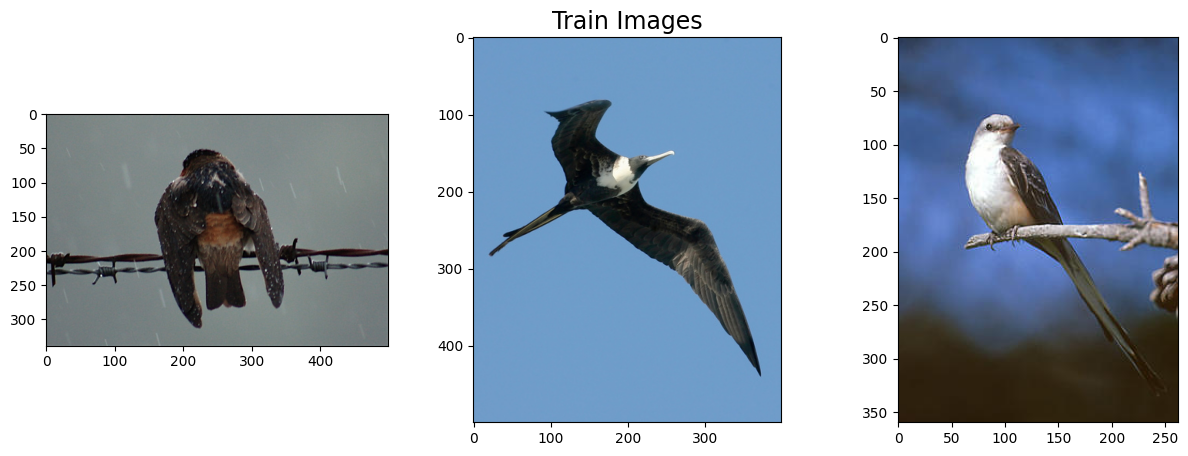

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(train_images[0:3]):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)

axes[1].set_title('Train Images',fontsize=17)
plt.show()

## Ploting First 3 Test Images

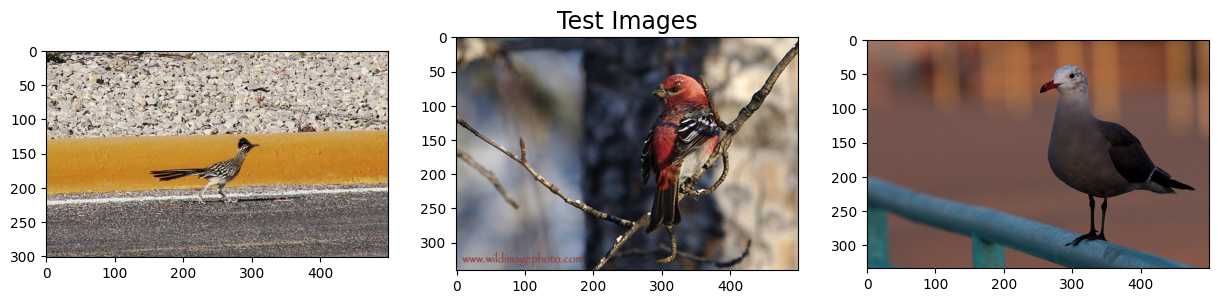

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(test_images[0:3]):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)

axes[1].set_title('Test Images',fontsize=17)
plt.show()

#Separating images according to classes  


In [ ]:
import os
import shutil
import pandas as pd
from PIL import Image

csv_path = '/content/train.csv'
df = pd.read_csv(csv_path)

#creating a base directory to store separated classes
base_dir = '/content/separated_classes/'
os.makedirs(base_dir, exist_ok=True)

for index, row in df.iterrows():
    image_path = row['path']
    class_label = row['class']
    bbox = row['bbox']# bounding box coordinates

    # creating class-specific directories if not exists
    class_dir = os.path.join(base_dir, str(class_label))
    os.makedirs(class_dir, exist_ok=True)

    if pd.notna(bbox):  #ensuring bbox is not "NaN"
        bbox = [int(float(x)) for x in bbox.strip('()').split()]
        # auto-correcting bounding box if values are swapped
        if bbox[2] < bbox[0]:
            bbox[0], bbox[2] = bbox[2], bbox[0]  #swaping x_min and x_max
        if bbox[3] < bbox[1]:
            bbox[1], bbox[3] = bbox[3], bbox[1]  # swaping y_min and y_max
        # validating the corrected bbox and crop the image
        if bbox[2] > bbox[0] and bbox[3] > bbox[1]:
            img = Image.open(image_path)
            cropped_img = img.crop((bbox[0], bbox[1], bbox[2], bbox[3]))  # croping using bbox coordinates
            save_path = os.path.join(class_dir, os.path.basename(image_path))
            cropped_img.save(save_path)

In [ ]:
train_data_size = len(train_images)
print(train_data_size)

5994


In [ ]:
test_data_size=len(test_images)
print(test_data_size)

5794


## Creating Validation Dataset from Train Dataset

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

train_dir = '/content/separated_classes'
valid_dir = '/content/images/valid'
os.makedirs(valid_dir, exist_ok=True)
for class_name in os.listdir(train_dir):
    class_train_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_train_dir):
        class_valid_dir = os.path.join(valid_dir, class_name)
        os.makedirs(class_valid_dir, exist_ok=True)
        if len(images) > 0:
            train_images, valid_images = train_test_split(images, test_size=0.1, random_state=42)
            for image in valid_images:
                shutil.move(os.path.join(class_train_dir, image), os.path.join(class_valid_dir, image))


#Adding Dummy Class to Test Data


In [ ]:
import os
import shutil
test_dir = '/content/images/test'
dummy_test_dir = os.path.join(test_dir, 'dummy_class')
os.makedirs(dummy_test_dir, exist_ok=True)
# moving all test images to the dummy class subdirectory
for filename in os.listdir(test_dir):
    file_path = os.path.join(test_dir, filename)
    if os.path.isfile(file_path):
        shutil.move(file_path, dummy_test_dir)

##CNN Model

Training and Testing CNN model


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import requests


#setting up data generators for training, validation, and testing
train_dir = '/content/separated_classes'
val_dir = '/content/images/valid'
test_dir = '/content/images/test'

# Image Data Generator with rescaling
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode=None,  # no labels for testing data
    shuffle=False
)


#CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Training the Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=60
)

#Predicting test dataset
predictions = model.predict(test_data, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)  # index of the highest probability
confidence_scores = np.max(predictions, axis=1)     # the highest probability as confidence

#generating CSV File
test_filenames = test_data.filenames
output_csv = pd.DataFrame({
    'path': test_filenames,
    'predicted_label': predicted_classes,
    'confidence_score': confidence_scores
})
csv_output_path_cnn = '/content/predictions.csv'
output_csv.to_csv(csv_output_path_cnn, index=False)

Found 4386 images belonging to 201 classes.
Found 1596 images belonging to 201 classes.
Found 5794 images belonging to 1 classes.
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


138/138 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.0028 - loss: 5.7905 - val_accuracy: 0.0081 - val_loss: 5.2984
Epoch 2/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.0033 - loss: 5.2900 - val_accuracy: 0.0107 - val_loss: 5.2647
Epoch 3/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.0202 - loss: 5.2085 - val_accuracy: 0.0100 - val_loss: 5.2369
Epoch 4/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.0594 - loss: 4.9022 - val_accuracy: 0.0163 - val_loss: 5.2215
Epoch 5/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.1388 - loss: 4.2468 - val_accuracy: 0.0157 - val_loss: 5.3732
Epoch 6/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.2595 - loss: 3.4963 - val_accuracy: 0.0182 - val_loss: 5.6733
Epoch 7/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.3885 - loss: 2.8210 - val_accuracy: 0.0132 - val_loss: 5.8921
Epoch 8/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.4566 - loss: 2.4427 - val_accuracy

Function to send prediction.csv to Test Server

In [ ]:
#Send Results for Evaluation
def send_results_for_evaluation(name, csv_file, email):
    url = "http://43.205.49.236:5050/inference"
    files = {'file': open(csv_file, 'rb')}
    data = {'email': email, 'name': name}
    response = requests.post(url, files=files, data=data)
    return response.json()

#Accuracy returned from test server


In [ ]:
print('Accuracy: ')
print(send_results_for_evaluation('Hariharan.R.B',csv_output_path_cnn, 'hariharan.2023@vitstudent.ac.in'))

Accuracy: 
{'overall_accuracy (%)': 0.58681, 'max_accuracy_class': 190, 'max_accuracy (%)': 10.0, 'min_accuracy_class': 16, 'min_accuracy (%)': 0.0}


##VGG-16 MODEL

Training and Testing VGG-16 Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# buliding the VGG-16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

vgg_model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])

vgg_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


# training VGG-16 model
vgg_history = vgg_model.fit(
    train_data,
    validation_data=val_data,
    epochs=60,
    verbose=1
)

#predictions on the Test Set
vgg_predictions = vgg_model.predict(test_data, verbose=1)
vgg_predicted_classes = np.argmax(vgg_predictions, axis=1)
vgg_confidence_scores = np.max(vgg_predictions, axis=1)



Epoch 1/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 95s 622ms/step - accuracy: 0.0043 - loss: 5.4858 - val_accuracy: 0.0050 - val_loss: 5.3021
Epoch 2/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 427ms/step - accuracy: 0.0055 - loss: 5.3014 - val_accuracy: 0.0050 - val_loss: 5.2997
Epoch 3/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 431ms/step - accuracy: 0.0061 - loss: 5.3042 - val_accuracy: 0.0025 - val_loss: 5.2958
Epoch 4/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 89s 483ms/step - accuracy: 0.0093 - loss: 5.2971 - val_accuracy: 0.0025 - val_loss: 5.2920
Epoch 5/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 434ms/step - accuracy: 0.0100 - loss: 5.2927 - val_accuracy: 0.0050 - val_loss: 5.2899
Epoch 6/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 439ms/step - accuracy: 0.0087 - loss: 5.2847 - val_accuracy: 0.0125 - val_loss: 5.2765
Epoch 7/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 448ms/step - accuracy: 0.0091 - loss: 5.2739 - val_accuracy: 0.0125 - val_loss: 5.2624
Epoch 8/60
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 440ms/step - accuracy: 0.0081 - loss: 5

Creating csv file |

In [ ]:
test_filenames = test_data.filenames
results_df = pd.DataFrame({
    'path': test_filenames,
    'predicted_label': vgg_predicted_classes,
    'confidence_score': vgg_confidence_scores
    })
csv_output_path_VGG16 = '/content/VGG16_predictions.csv'
results_df.to_csv(csv_output_path_VGG16, index=False)

Accuracy received from test server for VGG-16 model

In [ ]:
print('Accuracy: ')
print(send_results_for_evaluation('Hariharan.R.B', csv_output_path_VGG16, 'hariharan.2023@vitstudent.ac.in'))

Accuracy: 
{'overall_accuracy (%)': 0.53504, 'max_accuracy_class': 0, 'max_accuracy (%)': 36.66667, 'min_accuracy_class': 16, 'min_accuracy (%)': 0.0}


Accuracy of CNN= 87% is greater than VGG-16 and loss function=0.54 is also very less for CNN, but VGG-16 will also perform well if preprocess the data more by changing to black and white image, vectoring it,increasing epoch (need more GPU resource or else time taking task), as the acxcuracy is gradually increasing and  loss funcion also decreasing gradually.